## 🔧 Step 1: Mount Google Drive

In [2]:

# Navigate to project directory
import os
os.chdir('/content/drive/MyDrive/new_cattle_disease_detection')
print(f"✅ Current directory: {os.getcwd()}")

✅ Current directory: /content/drive/MyDrive/new_cattle_disease_detection


In [3]:
# Install Roboflow
!pip install -q roboflow

# Create base directory in Google Drive
import os
base_dir = '/content/drive/MyDrive/new_cattle_disease_detection'
os.makedirs(base_dir, exist_ok=True)
os.chdir(base_dir)
print(f"✅ Working directory: {os.getcwd()}")

# Download dataset from Roboflow
from roboflow import Roboflow
rf = Roboflow(api_key="B3AK2lkHdqLr3fZeXChP")
project = rf.workspace("cattle-diseasee-computer-vision-dataset").project("new-cattle-diseasee-hzipc")
version = project.version(2)
dataset = version.download("folder")

print(f"\n✅ Dataset downloaded to: {dataset.location}")
print(f"✅ Dataset structure: {base_dir}/New-Cattle-Disease-2/{{train,valid,test}}")
print("\n⚠️ If folder name is different, update TRAIN_PATH and VALID_PATH in Step 4!")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 22.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 81.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.2/4.2 MB 120.0 MB/s eta 0:00:00
✅ Working directory: /content/drive/MyDrive/new_cattle_disease_detection
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to New-Cattle-Diseasee-2 in folder:: 100%|██████████| 3677/3677 [00:28<00:00, 126.90it/s]


✅ Dataset downloaded to: /content/drive/MyDrive/new_cattle_disease_detection/New-Cattle-Diseasee-2
✅ Dataset structure: /content/drive/MyDrive/new_cattle_disease_detection/New-Cattle-Disease-2/{train,valid,test}

⚠️ If folder name is different, update TRAIN_PATH and VALID_PATH in Step 4!


## 📥 Step 1.5: Download Roboflow Dataset to Drive

## 🖥️ Step 2: Verify GPU and Install Dependencies

In [4]:
# Check GPU
!nvidia-smi

import tensorflow as tf
print(f"\n✅ TensorFlow Version: {tf.__version__}")
print(f"✅ GPU Devices: {tf.config.list_physical_devices('GPU')}")

# Enable mixed precision for T4 GPU (faster training)
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')
print("✅ Mixed precision enabled for T4 GPU")

Tue Dec 30 07:44:43 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   41C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
# Install additional packages (if needed)
!pip install -q seaborn scikit-learn

## 📚 Step 3: Import Libraries

In [6]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import os
from datetime import datetime
from tqdm import tqdm

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


## ⚙️ Step 4: Configuration (Optimized for T4 GPU)

**⚠️ IMPORTANT NOTE:**
This notebook was designed for severity classification (Mild/Moderate/Severe).
Your dataset has disease folders instead.

**Recommendation:** Use **Colab_EfficientNetB4_Disease_Classification.ipynb** for disease classification.

If you want to continue anyway, this will train on your disease classes.

In [22]:
# Configuration - Optimized for T4 GPU
CONFIG = {
    'IMAGE_SIZE': (224, 224),
    'BATCH_SIZE': 64,  # Increased for T4 GPU
    'EPOCHS': 100,
    'LEARNING_RATE': 0.0001,
    'NUM_CLASSES': 8,  # Will auto-detect from your disease folders
    'VALIDATION_SPLIT': 0.2,
    'SEED': 42
}

# Paths (Google Drive) - FIXED to match your actual folder name
BASE_PATH = '/content/drive/MyDrive/new_cattle_disease_detection'  # Changed: added "new_"
TRAIN_PATH = '/content/drive/MyDrive/new_cattle_disease_detection/New-Cattle-Diseasee-2/train'
VALID_PATH = '/content/drive/MyDrive/new_cattle_disease_detection/New-Cattle-Diseasee-2/valid'
CSV_PATH = f'{BASE_PATH}/datasets/cattle_treatment_dataset.csv'  # Optional - for reference only
MODEL_SAVE_PATH = f'{BASE_PATH}/models/DenseNet121_Disease'
LOGS_PATH = f'{BASE_PATH}/logs/densenet121'

# Create directories
os.makedirs(MODEL_SAVE_PATH, exist_ok=True)
os.makedirs(LOGS_PATH, exist_ok=True)

# Set random seeds
np.random.seed(CONFIG['SEED'])
tf.random.set_seed(CONFIG['SEED'])

print("✅ Configuration set!")
print(f"📁 Train path: {TRAIN_PATH}")
print(f"📁 Valid path: {VALID_PATH}")
print(f"💾 Models will be saved to: {MODEL_SAVE_PATH}")
print("\n⚠️  NOTE: Training on DISEASE classes, not severity!")

✅ Configuration set!
📁 Train path: /content/drive/MyDrive/new_cattle_disease_detection/New-Cattle-Diseasee-2/train
📁 Valid path: /content/drive/MyDrive/new_cattle_disease_detection/New-Cattle-Diseasee-2/valid
💾 Models will be saved to: /content/drive/MyDrive/new_cattle_disease_detection/models/DenseNet121_Disease

⚠️  NOTE: Training on DISEASE classes, not severity!


## 📊 Step 5: Load CSV Data (Optional - for reference)

In [13]:
# ⚠️ OPTIONAL: Load CSV to see severity distribution (NOT required for training)
# Skip this cell if you don't have the CSV file

try:
    df = pd.read_csv(CSV_PATH)

    print("Dataset Info:")
    print(df.head())
    print(f"\nTotal samples: {len(df)}")
    print(f"\nSeverity distribution:")
    print(df['Severity'].value_counts())

    # Filter disease cases
    df_disease = df[df['Disease'] != 'Healthy'].copy()
    severity_map = {0: 'Mild', 1: 'Moderate', 2: 'Severe'}
    df_disease['Severity_Label'] = df_disease['Severity'].map(severity_map)

    print("\n✅ Severity Distribution:")
    print(df_disease['Severity_Label'].value_counts())
except FileNotFoundError:
    print("⚠️ CSV file not found - skipping this step")
    print("✅ This is OK! The model will train from your image folders.")

⚠️ CSV file not found - skipping this step
✅ This is OK! The model will train from your image folders.


In [34]:
# Remove 'Unlabeled' folders from train and valid to ensure consistency
import shutil
import os

unlabeled_folders = [
    '/content/drive/MyDrive/new_cattle_disease_detection/New-Cattle-Diseasee-2/train/Unlabeled',
    '/content/drive/MyDrive/new_cattle_disease_detection/New-Cattle-Diseasee-2/valid/Unlabeled',
    '/content/drive/MyDrive/new_cattle_disease_detection/New-Cattle-Diseasee-2/test/Unlabeled'
]

removed_count = 0
for folder in unlabeled_folders:
    if os.path.exists(folder):
        shutil.rmtree(folder)
        print(f"✅ Removed: {folder}")
        removed_count += 1
    else:
        print(f"⏭️  Not found (OK): {folder}")

if removed_count > 0:
    print(f"\n🎉 Cleaned {removed_count} 'Unlabeled' folder(s)")
    print("⚠️  IMPORTANT: Re-run Step 6 to reload data generators with clean dataset!")
else:
    print("\n✅ No 'Unlabeled' folders found - dataset is clean!")
    print("💡 You can proceed to Step 6")

✅ Removed: /content/drive/MyDrive/new_cattle_disease_detection/New-Cattle-Diseasee-2/train/Unlabeled
⏭️  Not found (OK): /content/drive/MyDrive/new_cattle_disease_detection/New-Cattle-Diseasee-2/valid/Unlabeled
⏭️  Not found (OK): /content/drive/MyDrive/new_cattle_disease_detection/New-Cattle-Diseasee-2/test/Unlabeled

🎉 Cleaned 1 'Unlabeled' folder(s)
⚠️  IMPORTANT: Re-run Step 6 to reload data generators with clean dataset!


## 🖼️ Step 6: Data Augmentation and Generators

In [35]:
# Training data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest'
)

# Validation data (only rescaling)
val_datagen = ImageDataGenerator(rescale=1./255)

# Training generator - using your disease folders
train_generator = train_datagen.flow_from_directory(
    TRAIN_PATH,
    target_size=CONFIG['IMAGE_SIZE'],
    batch_size=CONFIG['BATCH_SIZE'],
    class_mode='categorical',
    shuffle=True,
    seed=CONFIG['SEED']
)

# Validation generator
val_generator = val_datagen.flow_from_directory(
    VALID_PATH,
    target_size=CONFIG['IMAGE_SIZE'],
    batch_size=CONFIG['BATCH_SIZE'],
    class_mode='categorical',
    shuffle=False,
    seed=CONFIG['SEED']
)

# Update NUM_CLASSES based on detected folders
CONFIG['NUM_CLASSES'] = len(train_generator.class_indices)

print(f"✅ Training samples: {train_generator.samples}")
print(f"✅ Validation samples: {val_generator.samples}")
print(f"✅ Number of classes: {CONFIG['NUM_CLASSES']}")
print(f"✅ Detected classes: {list(train_generator.class_indices.keys())}")

Found 2518 images belonging to 8 classes.
Found 575 images belonging to 8 classes.
✅ Training samples: 2518
✅ Validation samples: 575
✅ Number of classes: 8
✅ Detected classes: ['Contagious', 'dermatophilosis', 'fmd', 'healthy', 'lumpy skin', 'mastitis', 'pediculosis', 'ringworm']


## 🏗️ Step 7: Build Custom DenseNet121 Model

In [36]:
def build_densenet121_severity_model(input_shape=(224, 224, 3), num_classes=8):
    """
    Custom DenseNet121 architecture (T4 GPU optimized)
    Now configured for disease classification
    """
    # Load pre-trained DenseNet121
    base_model = DenseNet121(
        include_top=False,
        weights='imagenet',
        input_shape=input_shape,
        pooling='avg'
    )

    # Freeze early layers
    for layer in base_model.layers[:-50]:
        layer.trainable = False

    # Build model
    inputs = keras.Input(shape=input_shape)
    x = base_model(inputs, training=False)

    # Custom head
    x = layers.Dense(512, activation='relu', name='fc1')(x)
    x = layers.BatchNormalization(name='bn1')(x)
    x = layers.Dropout(0.5, name='dropout1')(x)

    x = layers.Dense(256, activation='relu', name='fc2')(x)
    x = layers.BatchNormalization(name='bn2')(x)
    x = layers.Dropout(0.4, name='dropout2')(x)

    # Output layer (float32 for mixed precision)
    outputs = layers.Dense(num_classes, activation='softmax', dtype='float32', name='disease_output')(x)

    model = keras.Model(inputs, outputs, name='DenseNet121_Disease')
    return model

# Build model with auto-detected number of classes
model = build_densenet121_severity_model(
    input_shape=(*CONFIG['IMAGE_SIZE'], 3),
    num_classes=CONFIG['NUM_CLASSES']
)

print("✅ Model built successfully!")
model.summary()

✅ Model built successfully!


Model: "DenseNet121_Disease"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 1024)           │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 512)            │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout1 (Dropout)              │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn2 (BatchNormalization)        │ (None, 256)            │         1,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout2 (Dropout)              │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ disease_output (Dense)          │ (None, 8)              │         2,056 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,698,760 (29.37 MB)

 Trainable params: 1,735,368 (6.62 MB)

 Non-trainable params: 5,963,392 (22.75 MB)

## ⚡ Step 8: Compile Model

In [37]:
# Compile model
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=CONFIG['LEARNING_RATE']),
    loss='categorical_crossentropy',
    metrics=[
        'accuracy',
        keras.metrics.Precision(name='precision'),
        keras.metrics.Recall(name='recall'),
        keras.metrics.AUC(name='auc')
    ]
)

print("✅ Model compiled successfully!")

✅ Model compiled successfully!


## 📞 Step 9: Setup Callbacks

In [38]:
# Callbacks
callbacks = [
    ModelCheckpoint(
        filepath=os.path.join(MODEL_SAVE_PATH, 'best_model.h5'),
        monitor='val_accuracy',
        mode='max',
        save_best_only=True,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_loss',
        patience=15,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

print("✅ Callbacks configured!")

✅ Callbacks configured!


## 🔥 Step 10: Train Model (T4 GPU Accelerated)

In [39]:
# CRITICAL: Verify model output matches dataset classes
print(f"📊 Dataset classes: {CONFIG['NUM_CLASSES']}")
print(f"🔧 Model output shape: {model.output_shape}")
print(f"📁 Detected disease classes: {list(train_generator.class_indices.keys())}")

# Check if there's a mismatch
expected_classes = len(train_generator.class_indices)
model_output_classes = model.output_shape[-1]

if model_output_classes != expected_classes:
    print(f"\n❌ MISMATCH DETECTED!")
    print(f"   Model has {model_output_classes} outputs but dataset has {expected_classes} classes")
    print(f"\n🔄 Rebuilding model with correct number of classes...")

    # Rebuild model with correct number of classes
    model = build_densenet121_severity_model(
        input_shape=(*CONFIG['IMAGE_SIZE'], 3),
        num_classes=expected_classes
    )

    # Recompile model
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=CONFIG['LEARNING_RATE']),
        loss='categorical_crossentropy',
        metrics=[
            'accuracy',
            keras.metrics.Precision(name='precision'),
            keras.metrics.Recall(name='recall'),
            keras.metrics.AUC(name='auc')
        ]
    )

    print(f"✅ Model rebuilt with {expected_classes} output classes!")
    print(f"✅ New model output shape: {model.output_shape}")
else:
    print(f"\n✅ Model configuration is correct!")
    print(f"   Both model and dataset have {expected_classes} classes")

📊 Dataset classes: 8
🔧 Model output shape: (None, 8)
📁 Detected disease classes: ['Contagious', 'dermatophilosis', 'fmd', 'healthy', 'lumpy skin', 'mastitis', 'pediculosis', 'ringworm']

✅ Model configuration is correct!
   Both model and dataset have 8 classes


In [31]:
# Add this as new cell and run
import shutil
unlabeled_train = '/content/drive/MyDrive/new_cattle_disease_detection/New-Cattle-Disease-2/train/Unlabeled'
if os.path.exists(unlabeled_train):
    shutil.rmtree(unlabeled_train)
    print("✅ Removed Unlabeled from train")
# Then re-run Step 6

In [40]:
# Train model
print("\n🚀 Starting training on T4 GPU...\n")

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // CONFIG['BATCH_SIZE'],
    validation_data=val_generator,
    validation_steps=val_generator.samples // CONFIG['BATCH_SIZE'],
    epochs=CONFIG['EPOCHS'],
    callbacks=callbacks,
    verbose=1
)

print("\n✅ Training completed!")


🚀 Starting training on T4 GPU...

Epoch 1/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.1857 - auc: 0.5617 - loss: 2.9399 - precision: 0.2070 - recall: 0.1050
Epoch 1: val_accuracy improved from -inf to 0.52148, saving model to /content/drive/MyDrive/new_cattle_disease_detection/models/DenseNet121_Disease/best_model.h5


39/39 ━━━━━━━━━━━━━━━━━━━━ 143s 2s/step - accuracy: 0.1870 - auc: 0.5633 - loss: 2.9318 - precision: 0.2094 - recall: 0.1063 - val_accuracy: 0.5215 - val_auc: 0.8289 - val_loss: 1.5767 - val_precision: 1.0000 - val_recall: 0.0508 - learning_rate: 1.0000e-04
Epoch 2/100
 1/39 ━━━━━━━━━━━━━━━━━━━━ 4s 107ms/step - accuracy: 0.3438 - auc: 0.6958 - loss: 2.2268 - precision: 0.4333 - recall: 0.2031

Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.



Epoch 2: val_accuracy improved from 0.52148 to 0.53516, saving model to /content/drive/MyDrive/new_cattle_disease_detection/models/DenseNet121_Disease/best_model.h5


39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 91ms/step - accuracy: 0.3438 - auc: 0.6958 - loss: 2.2268 - precision: 0.4333 - recall: 0.2031 - val_accuracy: 0.5352 - val_auc: 0.8359 - val_loss: 1.5563 - val_precision: 1.0000 - val_recall: 0.0664 - learning_rate: 1.0000e-04
Epoch 3/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 969ms/step - accuracy: 0.4142 - auc: 0.7716 - loss: 1.9182 - precision: 0.5291 - recall: 0.3144
Epoch 3: val_accuracy improved from 0.53516 to 0.78320, saving model to /content/drive/MyDrive/new_cattle_disease_detection/models/DenseNet121_Disease/best_model.h5


39/39 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.4154 - auc: 0.7722 - loss: 1.9146 - precision: 0.5304 - recall: 0.3156 - val_accuracy: 0.7832 - val_auc: 0.9453 - val_loss: 0.9925 - val_precision: 0.9665 - val_recall: 0.4512 - learning_rate: 1.0000e-04
Epoch 4/100
 1/39 ━━━━━━━━━━━━━━━━━━━━ 4s 110ms/step - accuracy: 0.5938 - auc: 0.8419 - loss: 1.5027 - precision: 0.6744 - recall: 0.4531
Epoch 4: val_accuracy improved from 0.78320 to 0.78516, saving model to /content/drive/MyDrive/new_cattle_disease_detection/models/DenseNet121_Disease/best_model.h5


39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.5938 - auc: 0.8419 - loss: 1.5027 - precision: 0.6744 - recall: 0.4531 - val_accuracy: 0.7852 - val_auc: 0.9466 - val_loss: 0.9814 - val_precision: 0.9675 - val_recall: 0.4648 - learning_rate: 1.0000e-04
Epoch 5/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 994ms/step - accuracy: 0.5710 - auc: 0.8565 - loss: 1.4564 - precision: 0.6769 - recall: 0.4713
Epoch 5: val_accuracy improved from 0.78516 to 0.83203, saving model to /content/drive/MyDrive/new_cattle_disease_detection/models/DenseNet121_Disease/best_model.h5


39/39 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.5716 - auc: 0.8568 - loss: 1.4546 - precision: 0.6779 - recall: 0.4721 - val_accuracy: 0.8320 - val_auc: 0.9652 - val_loss: 0.7053 - val_precision: 0.9468 - val_recall: 0.6953 - learning_rate: 1.0000e-04
Epoch 6/100
 1/39 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.6875 - auc: 0.9197 - loss: 1.0766 - precision: 0.7736 - recall: 0.6406
Epoch 6: val_accuracy improved from 0.83203 to 0.83398, saving model to /content/drive/MyDrive/new_cattle_disease_detection/models/DenseNet121_Disease/best_model.h5


39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 106ms/step - accuracy: 0.6875 - auc: 0.9197 - loss: 1.0766 - precision: 0.7736 - recall: 0.6406 - val_accuracy: 0.8340 - val_auc: 0.9653 - val_loss: 0.6999 - val_precision: 0.9471 - val_recall: 0.6992 - learning_rate: 1.0000e-04
Epoch 7/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 971ms/step - accuracy: 0.6667 - auc: 0.9075 - loss: 1.1485 - precision: 0.7659 - recall: 0.5801
Epoch 7: val_accuracy improved from 0.83398 to 0.84961, saving model to /content/drive/MyDrive/new_cattle_disease_detection/models/DenseNet121_Disease/best_model.h5


39/39 ━━━━━━━━━━━━━━━━━━━━ 77s 1s/step - accuracy: 0.6667 - auc: 0.9075 - loss: 1.1490 - precision: 0.7658 - recall: 0.5803 - val_accuracy: 0.8496 - val_auc: 0.9682 - val_loss: 0.6202 - val_precision: 0.9320 - val_recall: 0.7500 - learning_rate: 1.0000e-04
Epoch 8/100
 1/39 ━━━━━━━━━━━━━━━━━━━━ 4s 109ms/step - accuracy: 0.7188 - auc: 0.9246 - loss: 0.9918 - precision: 0.8235 - recall: 0.6562
Epoch 8: val_accuracy improved from 0.84961 to 0.85156, saving model to /content/drive/MyDrive/new_cattle_disease_detection/models/DenseNet121_Disease/best_model.h5


39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 92ms/step - accuracy: 0.7188 - auc: 0.9246 - loss: 0.9918 - precision: 0.8235 - recall: 0.6562 - val_accuracy: 0.8516 - val_auc: 0.9684 - val_loss: 0.6193 - val_precision: 0.9319 - val_recall: 0.7480 - learning_rate: 1.0000e-04
Epoch 9/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 998ms/step - accuracy: 0.7203 - auc: 0.9319 - loss: 0.9633 - precision: 0.8099 - recall: 0.6541
Epoch 9: val_accuracy improved from 0.85156 to 0.86328, saving model to /content/drive/MyDrive/new_cattle_disease_detection/models/DenseNet121_Disease/best_model.h5


39/39 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.7205 - auc: 0.9320 - loss: 0.9626 - precision: 0.8102 - recall: 0.6544 - val_accuracy: 0.8633 - val_auc: 0.9684 - val_loss: 0.6016 - val_precision: 0.9360 - val_recall: 0.7715 - learning_rate: 1.0000e-04
Epoch 10/100
 1/39 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.7656 - auc: 0.9604 - loss: 0.7441 - precision: 0.8136 - recall: 0.7500
Epoch 10: val_accuracy did not improve from 0.86328
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.7656 - auc: 0.9604 - loss: 0.7441 - precision: 0.8136 - recall: 0.7500 - val_accuracy: 0.8633 - val_auc: 0.9687 - val_loss: 0.6012 - val_precision: 0.9363 - val_recall: 0.7754 - learning_rate: 1.0000e-04
Epoch 11/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 977ms/step - accuracy: 0.7290 - auc: 0.9269 - loss: 1.0012 - precision: 0.8097 - recall: 0.6767
Epoch 11: val_accuracy improved from 0.86328 to 0.87695, saving model to /content/drive/MyDrive/new_cattle_disease_detection/models/DenseNet121_Disease/bes

39/39 ━━━━━━━━━━━━━━━━━━━━ 45s 1s/step - accuracy: 0.7296 - auc: 0.9272 - loss: 0.9987 - precision: 0.8101 - recall: 0.6773 - val_accuracy: 0.8770 - val_auc: 0.9730 - val_loss: 0.5493 - val_precision: 0.9420 - val_recall: 0.8242 - learning_rate: 1.0000e-04
Epoch 12/100
 1/39 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.7500 - auc: 0.9463 - loss: 0.8110 - precision: 0.8519 - recall: 0.7188
Epoch 12: val_accuracy did not improve from 0.87695
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 72ms/step - accuracy: 0.7500 - auc: 0.9463 - loss: 0.8110 - precision: 0.8519 - recall: 0.7188 - val_accuracy: 0.8770 - val_auc: 0.9729 - val_loss: 0.5491 - val_precision: 0.9420 - val_recall: 0.8242 - learning_rate: 1.0000e-04
Epoch 13/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 977ms/step - accuracy: 0.7831 - auc: 0.9500 - loss: 0.8135 - precision: 0.8461 - recall: 0.7333
Epoch 13: val_accuracy improved from 0.87695 to 0.87891, saving model to /content/drive/MyDrive/new_cattle_disease_detection/models/DenseNet121_Disease/bes

39/39 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.7828 - auc: 0.9501 - loss: 0.8134 - precision: 0.8461 - recall: 0.7331 - val_accuracy: 0.8789 - val_auc: 0.9762 - val_loss: 0.5183 - val_precision: 0.9355 - val_recall: 0.8496 - learning_rate: 1.0000e-04
Epoch 14/100
 1/39 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.7812 - auc: 0.9621 - loss: 0.7260 - precision: 0.8421 - recall: 0.7500
Epoch 14: val_accuracy did not improve from 0.87891
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - accuracy: 0.7812 - auc: 0.9621 - loss: 0.7260 - precision: 0.8421 - recall: 0.7500 - val_accuracy: 0.8789 - val_auc: 0.9761 - val_loss: 0.5186 - val_precision: 0.9372 - val_recall: 0.8457 - learning_rate: 1.0000e-04
Epoch 15/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 984ms/step - accuracy: 0.7989 - auc: 0.9600 - loss: 0.7094 - precision: 0.8558 - recall: 0.7531
Epoch 15: val_accuracy improved from 0.87891 to 0.89258, saving model to /content/drive/MyDrive/new_cattle_disease_detection/models/DenseNet121_Disease/bes

39/39 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.7987 - auc: 0.9600 - loss: 0.7097 - precision: 0.8557 - recall: 0.7528 - val_accuracy: 0.8926 - val_auc: 0.9790 - val_loss: 0.4719 - val_precision: 0.9417 - val_recall: 0.8516 - learning_rate: 1.0000e-04
Epoch 16/100
 1/39 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.7031 - auc: 0.9598 - loss: 0.7821 - precision: 0.8431 - recall: 0.6719
Epoch 16: val_accuracy did not improve from 0.89258
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.7031 - auc: 0.9598 - loss: 0.7821 - precision: 0.8431 - recall: 0.6719 - val_accuracy: 0.8926 - val_auc: 0.9784 - val_loss: 0.4705 - val_precision: 0.9418 - val_recall: 0.8535 - learning_rate: 1.0000e-04
Epoch 17/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 965ms/step - accuracy: 0.8093 - auc: 0.9604 - loss: 0.6945 - precision: 0.8633 - recall: 0.7672
Epoch 17: val_accuracy improved from 0.89258 to 0.89844, saving model to /content/drive/MyDrive/new_cattle_disease_detection/models/DenseNet121_Disease/bes

39/39 ━━━━━━━━━━━━━━━━━━━━ 78s 1s/step - accuracy: 0.8091 - auc: 0.9604 - loss: 0.6948 - precision: 0.8633 - recall: 0.7670 - val_accuracy: 0.8984 - val_auc: 0.9815 - val_loss: 0.4361 - val_precision: 0.9411 - val_recall: 0.8730 - learning_rate: 1.0000e-04
Epoch 18/100
 1/39 ━━━━━━━━━━━━━━━━━━━━ 3s 103ms/step - accuracy: 0.8281 - auc: 0.9702 - loss: 0.6540 - precision: 0.8475 - recall: 0.7812
Epoch 18: val_accuracy did not improve from 0.89844
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - accuracy: 0.8281 - auc: 0.9702 - loss: 0.6540 - precision: 0.8475 - recall: 0.7812 - val_accuracy: 0.8984 - val_auc: 0.9815 - val_loss: 0.4376 - val_precision: 0.9389 - val_recall: 0.8711 - learning_rate: 1.0000e-04
Epoch 19/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 979ms/step - accuracy: 0.8133 - auc: 0.9684 - loss: 0.6289 - precision: 0.8712 - recall: 0.7701
Epoch 19: val_accuracy improved from 0.89844 to 0.90039, saving model to /content/drive/MyDrive/new_cattle_disease_detection/models/DenseNet121_Disease/bes

39/39 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.8133 - auc: 0.9683 - loss: 0.6294 - precision: 0.8711 - recall: 0.7700 - val_accuracy: 0.9004 - val_auc: 0.9831 - val_loss: 0.4280 - val_precision: 0.9412 - val_recall: 0.8750 - learning_rate: 1.0000e-04
Epoch 20/100
 1/39 ━━━━━━━━━━━━━━━━━━━━ 3s 104ms/step - accuracy: 0.7812 - auc: 0.9609 - loss: 0.7090 - precision: 0.8448 - recall: 0.7656
Epoch 20: val_accuracy improved from 0.90039 to 0.90234, saving model to /content/drive/MyDrive/new_cattle_disease_detection/models/DenseNet121_Disease/best_model.h5


39/39 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - accuracy: 0.7812 - auc: 0.9609 - loss: 0.7090 - precision: 0.8448 - recall: 0.7656 - val_accuracy: 0.9023 - val_auc: 0.9822 - val_loss: 0.4264 - val_precision: 0.9412 - val_recall: 0.8750 - learning_rate: 1.0000e-04
Epoch 21/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 984ms/step - accuracy: 0.8288 - auc: 0.9715 - loss: 0.5819 - precision: 0.8939 - recall: 0.7904
Epoch 21: val_accuracy improved from 0.90234 to 0.90625, saving model to /content/drive/MyDrive/new_cattle_disease_detection/models/DenseNet121_Disease/best_model.h5


39/39 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.8288 - auc: 0.9715 - loss: 0.5818 - precision: 0.8938 - recall: 0.7904 - val_accuracy: 0.9062 - val_auc: 0.9837 - val_loss: 0.4018 - val_precision: 0.9324 - val_recall: 0.8887 - learning_rate: 1.0000e-04
Epoch 22/100
 1/39 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 0.7812 - auc: 0.9471 - loss: 0.8415 - precision: 0.8727 - recall: 0.7500
Epoch 22: val_accuracy did not improve from 0.90625
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - accuracy: 0.7812 - auc: 0.9471 - loss: 0.8415 - precision: 0.8727 - recall: 0.7500 - val_accuracy: 0.9062 - val_auc: 0.9837 - val_loss: 0.4010 - val_precision: 0.9325 - val_recall: 0.8906 - learning_rate: 1.0000e-04
Epoch 23/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 967ms/step - accuracy: 0.8295 - auc: 0.9690 - loss: 0.6059 - precision: 0.8764 - recall: 0.7930
Epoch 23: val_accuracy did not improve from 0.90625
39/39 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.8296 - auc: 0.9691 - loss: 0.6053 - precision: 0.8

39/39 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.8394 - auc: 0.9751 - loss: 0.5437 - precision: 0.8889 - recall: 0.8031 - val_accuracy: 0.9121 - val_auc: 0.9855 - val_loss: 0.3808 - val_precision: 0.9310 - val_recall: 0.8965 - learning_rate: 1.0000e-04
Epoch 26/100
 1/39 ━━━━━━━━━━━━━━━━━━━━ 4s 120ms/step - accuracy: 0.8594 - auc: 0.9805 - loss: 0.5155 - precision: 0.8814 - recall: 0.8125
Epoch 26: val_accuracy did not improve from 0.91211
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.8594 - auc: 0.9805 - loss: 0.5155 - precision: 0.8814 - recall: 0.8125 - val_accuracy: 0.9102 - val_auc: 0.9855 - val_loss: 0.3805 - val_precision: 0.9309 - val_recall: 0.8945 - learning_rate: 1.0000e-04
Epoch 27/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 984ms/step - accuracy: 0.8409 - auc: 0.9767 - loss: 0.5289 - precision: 0.8811 - recall: 0.8152
Epoch 27: val_accuracy did not improve from 0.91211
39/39 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.8410 - auc: 0.9768 - loss: 0.5284 - precision: 0.8

39/39 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.8524 - auc: 0.9800 - loss: 0.4762 - precision: 0.8919 - recall: 0.8244 - val_accuracy: 0.9141 - val_auc: 0.9864 - val_loss: 0.3756 - val_precision: 0.9372 - val_recall: 0.9043 - learning_rate: 1.0000e-04
Epoch 30/100
 1/39 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - accuracy: 0.8281 - auc: 0.9618 - loss: 0.6236 - precision: 0.8525 - recall: 0.8125
Epoch 30: val_accuracy did not improve from 0.91406
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.8281 - auc: 0.9618 - loss: 0.6236 - precision: 0.8525 - recall: 0.8125 - val_accuracy: 0.9141 - val_auc: 0.9863 - val_loss: 0.3768 - val_precision: 0.9372 - val_recall: 0.9043 - learning_rate: 1.0000e-04
Epoch 31/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8642 - auc: 0.9821 - loss: 0.4501 - precision: 0.9020 - recall: 0.8337
Epoch 31: val_accuracy did not improve from 0.91406
39/39 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.8643 - auc: 0.9821 - loss: 0.4497 - precision: 0.9022

39/39 ━━━━━━━━━━━━━━━━━━━━ 44s 1s/step - accuracy: 0.8567 - auc: 0.9808 - loss: 0.4777 - precision: 0.8930 - recall: 0.8256 - val_accuracy: 0.9160 - val_auc: 0.9870 - val_loss: 0.3704 - val_precision: 0.9333 - val_recall: 0.9023 - learning_rate: 1.0000e-04
Epoch 34/100
 1/39 ━━━━━━━━━━━━━━━━━━━━ 3s 105ms/step - accuracy: 0.8125 - auc: 0.9824 - loss: 0.4936 - precision: 0.8448 - recall: 0.7656
Epoch 34: val_accuracy did not improve from 0.91602
39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - accuracy: 0.8125 - auc: 0.9824 - loss: 0.4936 - precision: 0.8448 - recall: 0.7656 - val_accuracy: 0.9160 - val_auc: 0.9871 - val_loss: 0.3696 - val_precision: 0.9333 - val_recall: 0.9023 - learning_rate: 1.0000e-04
Epoch 35/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 994ms/step - accuracy: 0.8781 - auc: 0.9869 - loss: 0.3891 - precision: 0.9148 - recall: 0.8461
Epoch 35: val_accuracy did not improve from 0.91602
39/39 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.8778 - auc: 0.9869 - loss: 0.3900 - precision: 0.9

39/39 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.8623 - auc: 0.9837 - loss: 0.4296 - precision: 0.9043 - recall: 0.8446 - val_accuracy: 0.9199 - val_auc: 0.9861 - val_loss: 0.3618 - val_precision: 0.9379 - val_recall: 0.9141 - learning_rate: 1.0000e-04
Epoch 40/100
 1/39 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.9375 - auc: 0.9975 - loss: 0.2194 - precision: 0.9655 - recall: 0.8750
Epoch 40: val_accuracy did not improve from 0.91992
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - accuracy: 0.9375 - auc: 0.9975 - loss: 0.2194 - precision: 0.9655 - recall: 0.8750 - val_accuracy: 0.9199 - val_auc: 0.9860 - val_loss: 0.3630 - val_precision: 0.9398 - val_recall: 0.9141 - learning_rate: 1.0000e-04
Epoch 41/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 994ms/step - accuracy: 0.8667 - auc: 0.9827 - loss: 0.4288 - precision: 0.8978 - recall: 0.8404
Epoch 41: val_accuracy did not improve from 0.91992
39/39 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.8670 - auc: 0.9828 - loss: 0.4279 - precision: 0.8

39/39 ━━━━━━━━━━━━━━━━━━━━ 43s 1s/step - accuracy: 0.8809 - auc: 0.9879 - loss: 0.3683 - precision: 0.9108 - recall: 0.8527 - val_accuracy: 0.9258 - val_auc: 0.9889 - val_loss: 0.3373 - val_precision: 0.9438 - val_recall: 0.9180 - learning_rate: 1.0000e-04
Epoch 44/100
 1/39 ━━━━━━━━━━━━━━━━━━━━ 4s 108ms/step - accuracy: 0.9219 - auc: 0.9945 - loss: 0.2762 - precision: 0.9333 - recall: 0.8750
Epoch 44: val_accuracy did not improve from 0.92578
39/39 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - accuracy: 0.9219 - auc: 0.9945 - loss: 0.2762 - precision: 0.9333 - recall: 0.8750 - val_accuracy: 0.9258 - val_auc: 0.9880 - val_loss: 0.3378 - val_precision: 0.9438 - val_recall: 0.9180 - learning_rate: 1.0000e-04
Epoch 45/100
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.8956 - auc: 0.9912 - loss: 0.3225 - precision: 0.9276 - recall: 0.8742
Epoch 45: val_accuracy did not improve from 0.92578
39/39 ━━━━━━━━━━━━━━━━━━━━ 42s 1s/step - accuracy: 0.8956 - auc: 0.9912 - loss: 0.3225 - precision: 0.9276

## 📈 Step 11: Plot Training History

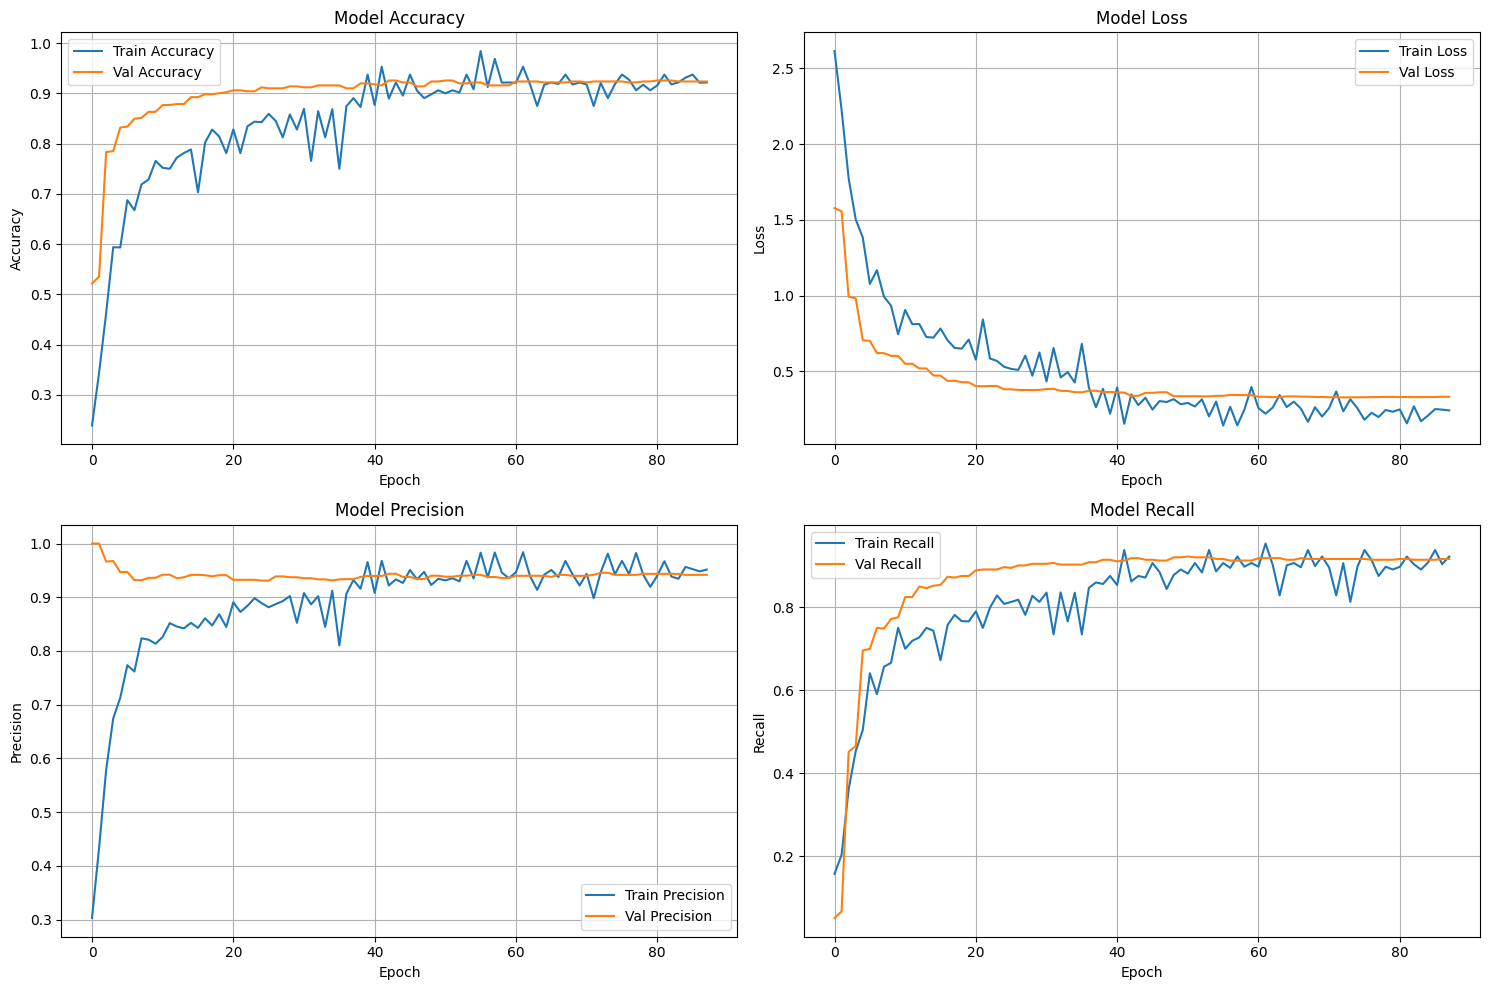

In [41]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Accuracy
axes[0, 0].plot(history.history['accuracy'], label='Train Accuracy')
axes[0, 0].plot(history.history['val_accuracy'], label='Val Accuracy')
axes[0, 0].set_title('Model Accuracy')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Accuracy')
axes[0, 0].legend()
axes[0, 0].grid(True)

# Loss
axes[0, 1].plot(history.history['loss'], label='Train Loss')
axes[0, 1].plot(history.history['val_loss'], label='Val Loss')
axes[0, 1].set_title('Model Loss')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Loss')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Precision
axes[1, 0].plot(history.history['precision'], label='Train Precision')
axes[1, 0].plot(history.history['val_precision'], label='Val Precision')
axes[1, 0].set_title('Model Precision')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Precision')
axes[1, 0].legend()
axes[1, 0].grid(True)

# Recall
axes[1, 1].plot(history.history['recall'], label='Train Recall')
axes[1, 1].plot(history.history['val_recall'], label='Val Recall')
axes[1, 1].set_title('Model Recall')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Recall')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.savefig(os.path.join(MODEL_SAVE_PATH, 'training_history.png'))
plt.show()

## 📊 Step 12: Evaluate Model

9/9 ━━━━━━━━━━━━━━━━━━━━ 35s 3s/step

📊 Classification Report:
                 precision    recall  f1-score   support

     Contagious       0.00      0.00      0.00         1
dermatophilosis       0.43      0.20      0.27        15
            fmd       0.87      0.83      0.85        47
        healthy       0.93      0.96      0.95       271
     lumpy skin       0.91      0.96      0.94       177
       mastitis       0.88      0.83      0.85        35
    pediculosis       0.33      0.33      0.33        15
       ringworm       0.60      0.43      0.50        14

       accuracy                           0.89       575
      macro avg       0.62      0.57      0.59       575
   weighted avg       0.88      0.89      0.88       575



Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.


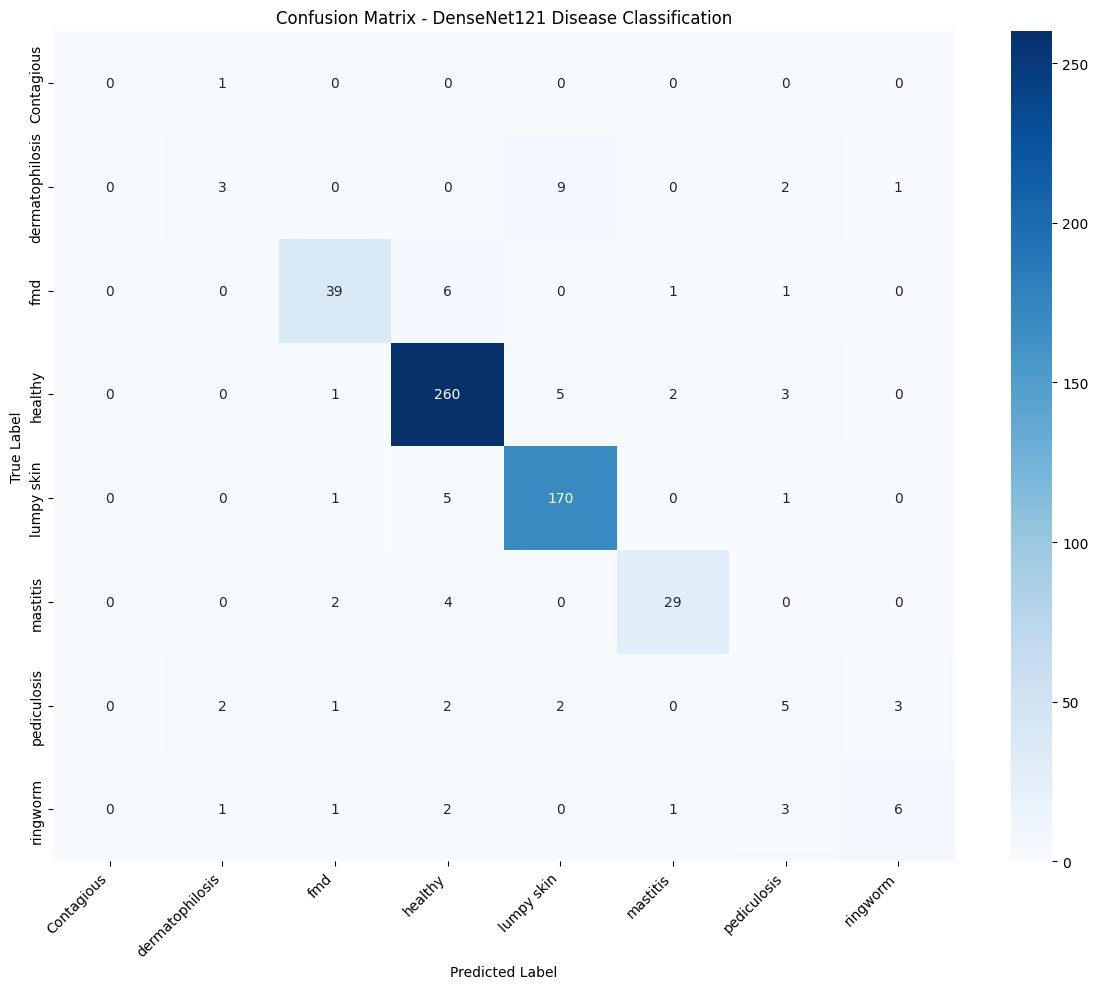

In [42]:
# Evaluate on validation set
val_generator.reset()
val_predictions = model.predict(val_generator, steps=val_generator.samples // CONFIG['BATCH_SIZE'] + 1)
val_pred_classes = np.argmax(val_predictions, axis=1)
val_true_classes = val_generator.classes[:len(val_pred_classes)]

# Get class names from generator
class_names = list(train_generator.class_indices.keys())
print("\n📊 Classification Report:")
print(classification_report(val_true_classes, val_pred_classes, target_names=class_names))

# Confusion matrix
cm = confusion_matrix(val_true_classes, val_pred_classes)
plt.figure(figsize=(12, 10))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - DenseNet121 Disease Classification')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig(os.path.join(MODEL_SAVE_PATH, 'confusion_matrix.png'))
plt.show()

## 💾 Step 13: Save Final Model

In [43]:
# Save in multiple formats
model.save(os.path.join(MODEL_SAVE_PATH, 'densenet121_severity_final.h5'))
model.save(os.path.join(MODEL_SAVE_PATH, 'densenet121_severity_final.keras'))

print(f"\n✅ Model saved to Google Drive: {MODEL_SAVE_PATH}")
print("\nModel files:")
print("- best_model.h5 (best checkpoint)")
print("- densenet121_severity_final.h5")
print("- densenet121_severity_final.keras")
print("\n💡 Download these files from your Google Drive!")


✅ Model saved to Google Drive: /content/drive/MyDrive/new_cattle_disease_detection/models/DenseNet121_Disease

Model files:
- best_model.h5 (best checkpoint)
- densenet121_severity_final.h5
- densenet121_severity_final.keras

💡 Download these files from your Google Drive!


## 🧪 Step 14: Test Inference

In [57]:
# Load best model
best_model = keras.models.load_model(os.path.join(MODEL_SAVE_PATH, 'best_model.h5'))

# Load class indices
class_indices = train_generator.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}

def predict_disease(image_path, model):
    img = keras.preprocessing.image.load_img(image_path, target_size=CONFIG['IMAGE_SIZE'])
    img_array = keras.preprocessing.image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0) / 255.0

    prediction = model.predict(img_array)
    disease_idx = np.argmax(prediction)
    confidence = prediction[0][disease_idx]

    return idx_to_class[disease_idx], confidence

# Test with a sample image - FIXED PATH
test_image = '/content/drive/MyDrive/new_cattle_disease_detection/New-Cattle-Diseasee-2/test/pediculosis/OIP-11-_jpg.rf.3c7b38b4d4cdf8c70777f65ea760498c.jpg'
disease, conf = predict_disease(test_image, best_model)
print(f"\n🧪 Test Results:")
print(f"📁 Image: {test_image.split('/')[-1]}")
print(f"🎯 Predicted Disease: {disease}")
print(f"💯 Confidence: {conf:.2%}")

print("\n✅ Model training and evaluation completed!")
print("✅ All files saved to Google Drive")
print(f"\n📊 Trained on {CONFIG['NUM_CLASSES']} disease classes")

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step

🧪 Test Results:
📁 Image: OIP-11-_jpg.rf.3c7b38b4d4cdf8c70777f65ea760498c.jpg
🎯 Predicted Disease: pediculosis
💯 Confidence: 68.88%

✅ Model training and evaluation completed!
✅ All files saved to Google Drive

📊 Trained on 8 disease classes
